In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#表示の幅を広げる
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

uketsuke = pd.read_csv('大黒屋様_買取受付一覧 - 受付一覧.csv', low_memory=False)
kaitori = pd.read_csv('出張買取実績_20200819以前.csv', low_memory=False)
#uketsuke.head()
#kaitori.head()

## 買取実績データを可視化

In [2]:
import matplotlib.font_manager
#print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

grouped = kaitori.groupby('都道府県')
#グループ化したGroupByオブジェクトはDataframeであるので、これをそのままplotできる
print(type(grouped.count()))

#確定日時がobject型であるのでそれをdatetime型に変更
uketsuke['確定日時'] = pd.to_datetime(uketsuke['確定日時'])
#uketsuke.dtypes

<class 'pandas.core.frame.DataFrame'>


## "kaitori"内の姓名(カナ)が半角なのでそれを全角に変える
#### カナを軸に結合するため修正が必要

In [3]:
#Gitから日本語変換できるライブラリをインストール
!python3.8 -m pip install --upgrade pip
!pip install jaconv
import jaconv

Requirement already up-to-date: pip in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages (20.2.4)


In [4]:
#一旦、dictにいれる
L = []
for i in kaitori['姓名（カナ）']:
    a = jaconv.h2z(i)
    L.append(a)
    
#'カナ'というカラムを一旦作る
kaitori['カナ'] = '名前'
kaitori.head()

for i in range(len(L)):
    kaitori['カナ'][i] = L[i]
kaitori.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,仕入番号,買取日付,点数,金額,会員番号,氏名,姓名（カナ）,郵便番号,都道府県,住所1,住所2,住所3,電話番号,性別,生年月日,カナ
0,4300016249,2020/04/04,2,7000,'5000000000186206,黒川 恵美,ｸﾛｶﾜ ｴﾐ,104-0051,東京都,中央区佃1-5-11,NaN,NaN,NaN,女性,1953/10/17,クロカワ エミ
1,6600000004,2020/06/13,4,245000,'5000000000187587,高嶺 小百合,ﾀｶﾐﾈ ｻﾕﾘ,102-0082,東京都,千代田区一番町9-10,NaN,NaN,NaN,女性,1961/12/20,タカミネ サユリ
2,6600000028,2020/07/03,1,2200,'5000000000187550,山室 まつ,ﾔﾏﾑﾛ ﾏﾂ,263-0013,千葉県,千葉市稲毛区千草台,2-2-25-507,NaN,NaN,女性,1945/06/20,ヤマムロ マツ
3,6600000043,2020/07/08,2,71500,'5000000000187536,鈴木 理夫,ｽｽﾞｷ ﾏｻｵ,166-0003,東京都,杉並区高円寺南,5-24-11,NaN,NaN,女性,1940/06/04,スズキ マサオ
4,6600000051,2020/07/12,5,34100,'5000000000187528,吉田 光子,ﾖｼﾀﾞ ﾐﾂｺ,112-0002,東京都,文京区小石川,5-40-1,グリーンハウス401,NaN,女性,1969/10/02,ヨシダ ミツコ


## 受付・買取データを結合する

In [5]:
#受付データと買取データ同士で重複している列を買取データ上から削除する
on = ['性別','郵便番号','姓名（カナ）']
kaitori.drop(on, axis=1, inplace=True)

#不必要な列を受付データ上から削除する
on = ['生年月日','Unnamed: 46','Unnamed: 47', 'Unnamed: 48']
uketsuke.drop(on, axis=1, inplace=True)

#"カナ"があるデータで結合する
df0 = pd.merge(uketsuke, kaitori, on='カナ', how='inner')

#必要なカラムだけ書く
on = ['処理状況', '確定日時', '担当', '買取番号', '入電日', '姓（カナ）', '名（カナ）', '姓名', 'カナ', '性別', '年齢', '住所・都道府県', '住所・市町村','建物名/部屋番号','キャンペーンコード', '住所1','住所2', '住所3','出張買取希望日時\n希望日','仕入番号','買取日付','点数','金額','会員番号', '生年月日']
df0 = df0[on]

#データの情報量を確認してみる
def f():
    a=len(kaitori) #出張買取の件数
    b=len(uketsuke) #買取受付の件数
    c=len(df0) #出張買取と買取受付を結合したもの。同一の人が複数あるせいで "a"より行数が多い
    return (a, b, c)

## 居住地域の情報を分割してわかりやすくする

In [6]:
#住所・市町村のカラム内で欠損している行を削除して、df1にいれる
df1 = df0.dropna(subset=['住所・都道府県','住所・市町村'])
pd.isna(df1['住所・市町村'])

#東京都とそれ以外で分ける
data_tokyo = df1[df1['住所・都道府県'].str.contains('東京')]
data1 = data_tokyo[data_tokyo['住所・市町村'].str.contains('区')] #東京23区を抽出
data_others = df1[~df1['住所・市町村'].str.contains('区')] #東京23区以外を抽出

#東京都23区について
#区で分けて、それを元のdfにいれる
new = data1['住所・市町村'] .str.split("区", n = 1, expand = True) 
new[0] = new[0]+"区"
data1['住所1'] = new[0]
data1['住所2'] = new[1]

#必要な情報のみを抽出
on = ['点数', '金額','住所1']
data2 = data1[on]
data3 = data2.groupby('住所1').sum()
df3 = pd.DataFrame(data3)
df3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,点数,金額
住所1,,
世田谷区,77,2316100
中央区,4,157000
中野区,17,30250
北区,3,23100
千代田区,48,765000
台東区,12,40370
品川区,3,38500
大田区,34,323400
文京区,18,1122100


In [7]:
#23区以外
on = ['点数', '金額','住所・都道府県']
data_others2 = data_others[on]
data_others3 = data_others2.groupby('住所・都道府県').sum()
df_others = pd.DataFrame(data_others3)
df_others

,点数,金額
住所・都道府県,,
千葉県,48,3712350
東京都,1,100
神奈川県,11,62000
長野県,4,6000


In [8]:
#エクセルに出力
#df_others.to_excel('エリア(区以外)ごとの買取総額0319-0804.xlsx')

In [9]:
#大黒屋のリアル店舗
tokyo_tenpo = ['上野店', '六本木店', '新宿二番館', '新宿本店', '池袋店', '池袋西口店', '渋谷店', '町田店', '銀座中央通り店', '銀座店', '麻布十番店']
chiba_tenpp = ['船橋店', '柏店', '成田店', '千葉店']
kanagawa_tenpo = ['横浜店', '川崎店']
saitama_tenpo = ['大宮店']
osaka_tenpo = ['大阪ミナミ店', '心斎橋店', '梅田店']

## Excelファイルに出力

In [10]:
!pip install xlwt
!pip install openpyxl
import pprint

In [11]:
#エクセルファイルとして出力
#df0.to_excel('受付_買取1.xlsx')

## 地図上にプロット

In [12]:
conda install geopandas

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
conda install descartes

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [14]:
input_path = "shapefile" # 展開先フォルダ名

# e-stat 国勢調査 小地域（町丁・字等別） 東京都全域
shapefile_url = "https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=13&coordSys=1&format=shape&downloadType=5"
shapefile_name = "tokyo.zip"

# ダウンロード
from urllib.request import urlretrieve
urlretrieve(url=shapefile_url, filename=shapefile_name)

# 解凍
import zipfile
with zipfile.ZipFile(shapefile_name) as existing_zip:
    existing_zip.extractall(input_path)

# ファイル名を取得
import os
files = os.listdir(input_path)
shapefile = [file for file in files if ".shp" in file][0]
print(f"downloaded shapefile: {shapefile}")

# 読み込み
import geopandas as gpd
shapefile_path = os.path.join(input_path, shapefile)
df = gpd.read_file(shapefile_path, encoding='cp932')
print(f"{shapefile_path} is loaded")

# 東京都の島嶼部を除く
import pandas as pd
islands = ['大島町', '利島村', '新島村', '神津島村', '三宅村', '御蔵島村', '八丈町', '青ヶ島村', '小笠原村']
is_not_islands = [df["CITY_NAME"] != island for island in islands]
is_not_islands = pd.concat(is_not_islands, axis=1).all(axis=1)
df = df.loc[is_not_islands, :]

# 陸地だけにする
df = df.loc[df["HCODE"] == 8101, :]

downloaded shapefile: h27ka13.shp
shapefile/h27ka13.shp is loaded


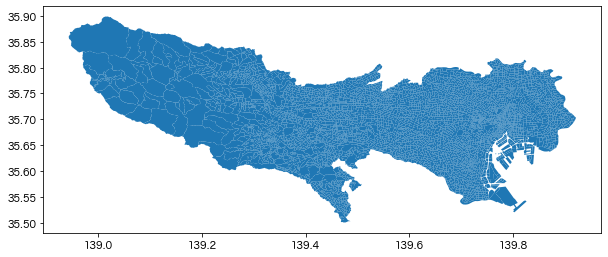

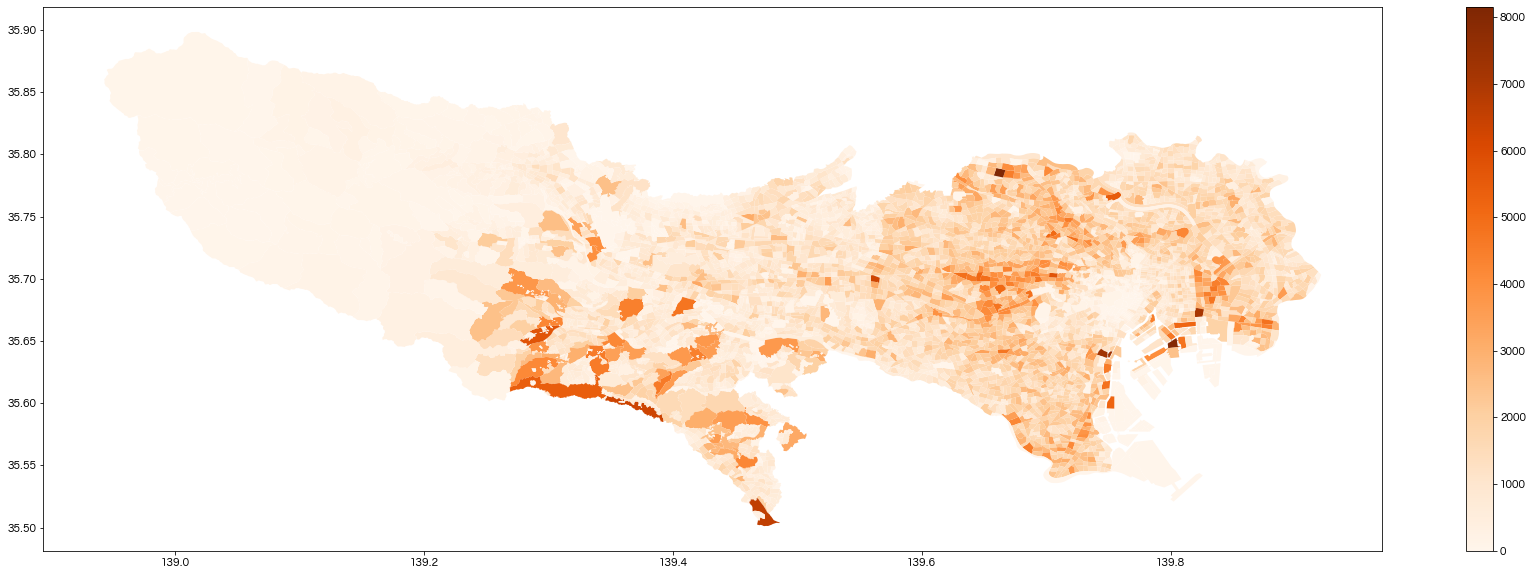

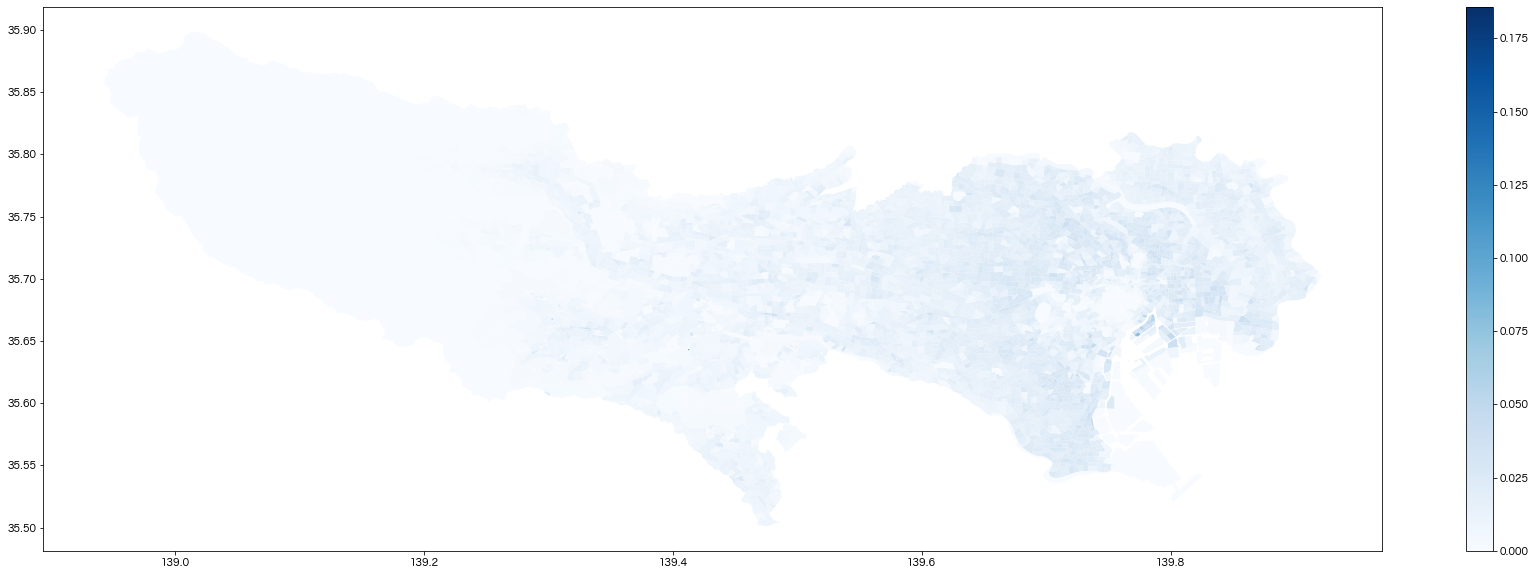

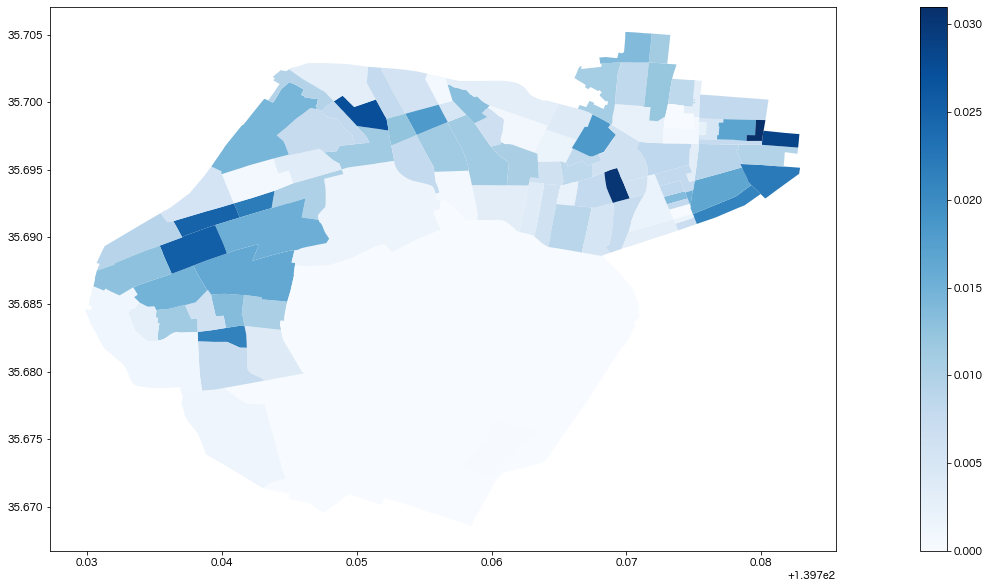

In [15]:
#お試し
df.plot(figsize=[10,10])

# 人口で塗り分け
df.plot(column="SETAI", legend=True, figsize=[30,10], cmap="Oranges")

# 人口密度で塗り分け
df["pop_density"] = df["JINKO"] / df["AREA"]
df.plot(column="pop_density", legend=True, figsize=[30,10], cmap="Blues")

# 値ラベル用にgeometryから当該ポリゴン内のある地点を取得
df["coords"] = df["geometry"].apply(lambda x: x.representative_point().coords[:])
df["coords"] = [coords[0] for coords in df["coords"]]

# 文京区の人口密度
temp = df.query("CITY_NAME == '千代田区'")
temp.plot(column="pop_density", legend=True, figsize=[30,10], cmap="Blues")

## 区別に出した買取総額と地図情報を結合

In [16]:
#pythonで出力した区別の情報をインストール
df4 = pd.read_excel('/Users/satoshiido/Downloads/大黒屋/オフライン - チラシ/区ごとの買取総額0319-0804.xlsx')

#結合軸となるカラムの名前を揃えるために、df4の"住所"の名前を変える
df4.rename(columns={'住所':'CITY_NAME'}, inplace=True)

#2つのdataframeを結合させる
df = pd.merge(df, df4, on='CITY_NAME', how='left')
df4

,CITY_NAME,買取点数,金額,一点あたりの買取平均金額
0,世田谷区,77,2316100,30079.220779
1,中央区,4,157000,39250.000000
2,中野区,17,30250,1779.411765
3,北区,3,23100,7700.000000
4,千代田区,48,765000,15937.500000
5,台東区,12,40370,3364.166667
6,品川区,3,38500,12833.333333
7,大田区,34,323400,9511.764706
8,文京区,18,1122100,62338.888889
9,新宿区,17,162380,9551.764706


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


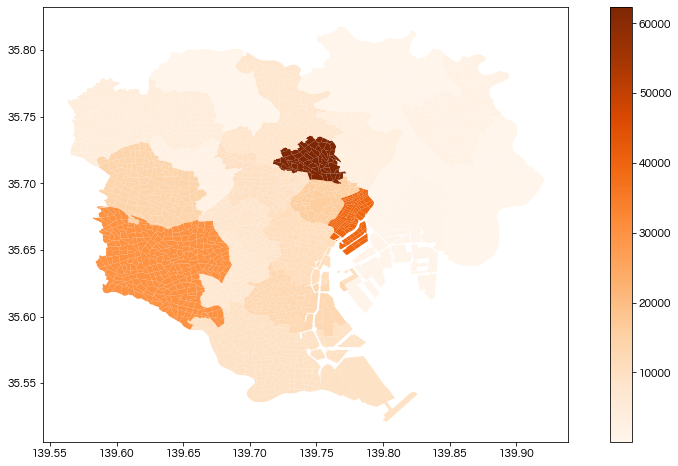

In [17]:
money = df.query("CITY_NAME == '中央区' | CITY_NAME == '世田谷区' | CITY_NAME == '中野区' |  CITY_NAME == '北区' | CITY_NAME == '千代田区' | CITY_NAME == '台東区' | CITY_NAME == '品川区' | CITY_NAME == '大田区' | CITY_NAME == '文京区' | CITY_NAME == '新宿区' | CITY_NAME == '杉並区' | CITY_NAME == '江戸川区' | CITY_NAME == '江東区' | CITY_NAME == '渋谷区' | CITY_NAME == '港区' | CITY_NAME == '目黒区' | CITY_NAME == '練馬区' | CITY_NAME == '荒川区' | CITY_NAME == '葛飾区' | CITY_NAME == '豊島区' | CITY_NAME == '足立区' | CITY_NAME == '墨田区' | CITY_NAME == '板橋区' ")
#一点あたりの平均金額で色付けする
money.plot(column="一点あたりの買取平均金額", legend=True, figsize=[15,8], cmap="Oranges")


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


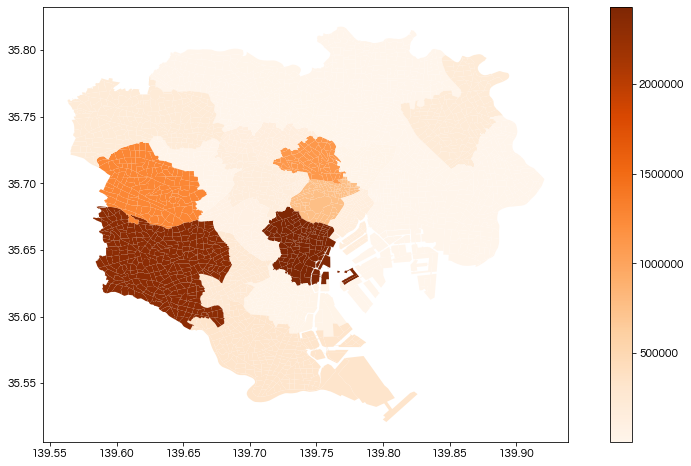

In [18]:
#総額で色付け
money.plot(column="金額", legend=True, figsize=[15,8], cmap="Oranges")

In [19]:
kokuzei0 = pd.read_csv('2015国政調査・小地域集計.csv', low_memory=False)
kokuzei0[(kokuzei0["市区町村名"]=="港区") | (kokuzei0["大字・町名"]=="麻布十番")  ] #(kokuzei0["字・丁目名"]=="1丁目")

,5,市区町村コード,町丁字コード,地域識別番号,秘匿処理,秘匿先情報,合算地域,都道府県名,市区町村名,大字・町名,字・丁目名,一般世帯総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯,主世帯,持ち家,公営・都市再生機構・公社の借家,民営の借家,給与住宅,間借り,住宅以外に住む一般世帯,住居の種類「不詳」,一般世帯人員総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯.1,主世帯.1,持ち家.1,公営・都市再生機構・公社の借家.1,民営の借家.1,給与住宅.1,間借り.1,住宅以外に住む一般世帯.1,住居の種類「不詳」.1,1世帯当たり人員総数（住居の種類・住宅の所有の関係）,住宅に住む一般世帯.2,主世帯.2,持ち家.2,公営・都市再生機構・公社の借家.2,民営の借家.2,給与住宅.2,間借り.2,住宅以外に住む一般世帯.2,住居の種類「不詳」.2
268,274,13103,NaN,1,NaN,NaN,NaN,東京都,港区,NaN,NaN,130487,128752,127765,63497,9288,49022,5958,987,1735,-,241605,239550,237916,131876,18679,75731,11630,1634,2055,-,1.8515637573,1.8605536225,1.8621375181,2.0768855222,2.0110895780,1.5448370120,1.9519973145,1.6555217832,1.1844380403,-
269,275,13103,10.0,2,NaN,NaN,NaN,東京都,港区,芝,NaN,7992,7944,7845,2990,1037,3533,285,99,48,-,13343,13282,13152,5978,1769,4948,457,130,61,-,1.6695445445,1.6719536757,1.6764818356,1.9993311037,1.7058823529,1.4005094820,1.6035087719,1.3131313131,1.2708333333,-
270,276,13103,1001.0,3,NaN,NaN,NaN,東京都,港区,芝,１丁目,925,914,885,267,102,481,35,29,11,-,1539,1523,1489,557,283,601,48,34,16,-,1.6637837838,1.6663019694,1.6824858757,2.0861423221,2.7745098039,1.2494802495,1.3714285714,1.1724137931,1.4545454545,-
271,277,13103,1002.0,3,NaN,NaN,NaN,東京都,港区,芝,２丁目,1737,1715,1695,767,-,820,108,20,22,-,3002,2977,2947,1536,-,1216,195,30,25,-,1.7282671272,1.7358600583,1.7386430678,2.0026075619,-,1.4829268293,1.8055555556,1.5000000000,1.1363636364,-
272,278,13103,1003.0,3,NaN,NaN,NaN,東京都,港区,芝,３丁目,2017,2015,1994,759,-,1187,48,21,2,-,3452,3450,3418,1577,-,1772,69,32,2,-,1.7114526525,1.7121588089,1.7141424273,2.0777338603,-,1.4928390901,1.4375000000,1.5238095238,1.0000000000,-
273,279,13103,1004.0,3,NaN,NaN,NaN,東京都,港区,芝,４丁目,1313,1309,1288,741,-,497,50,21,4,-,2259,2252,2226,1486,-,666,74,26,7,-,1.7204874334,1.7203972498,1.7282608696,2.0053981107,-,1.3400402414,1.4800000000,1.2380952381,1.7500000000,-
274,280,13103,1005.0,3,NaN,NaN,NaN,東京都,港区,芝,５丁目,2000,1991,1983,456,935,548,44,8,9,-,3091,3080,3072,822,1486,693,71,8,11,-,1.5455000000,1.5469613260,1.5491679274,1.8026315789,1.5893048128,1.2645985401,1.6136363636,1.0000000000,1.2222222222,-
275,281,13103,20.0,2,NaN,NaN,NaN,東京都,港区,海岸,NaN,3822,3729,3694,726,789,1864,315,35,93,-,6147,6053,6013,1360,1640,2574,439,40,94,-,1.6083202512,1.6232233843,1.6277747699,1.8732782369,2.0785804816,1.3809012876,1.3936507937,1.1428571429,1.0107526882,-
276,282,13103,2001.0,3,NaN,NaN,NaN,東京都,港区,海岸,１丁目,1277,1273,1243,111,523,558,51,30,4,-,2042,2038,2004,162,962,772,108,34,4,-,1.5990602976,1.6009426551,1.6122284795,1.4594594595,1.8393881453,1.3835125448,2.1176470588,1.1333333333,1.0000000000,-
277,283,13103,2002.0,3,NaN,NaN,NaN,東京都,港区,海岸,２丁目,361,358,356,284,-,62,10,2,3,-,710,707,705,588,-,101,16,2,3,-,1.9667590028,1.9748603352,1.9803370787,2.0704225352,-,1.6290322581,1.6000000000,1.0000000000,1.0000000000,-
